In [56]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import gzip
import os

import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import random_seed
from tensorflow.python.platform import gfile
from tensorflow.python.util.deprecation import deprecated

_Datasets = collections.namedtuple('_Datasets', ['train', 'validation', 'test'])

# CVDF mirror of http://yann.lecun.com/exdb/mnist/
DEFAULT_SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'


def _read32(bytestream):
  dt = numpy.dtype(numpy.uint32).newbyteorder('>')
  return numpy.frombuffer(bytestream.read(4), dtype=dt)[0]


@deprecated(None, 'Please use tf.data to implement this functionality.')
def _extract_images(f):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
  Args:
    f: A file object that can be passed into a gzip reader.
  Returns:
    data: A 4D uint8 numpy array [index, y, x, depth].
  Raises:
    ValueError: If the bytestream does not start with 2051.
  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                       (magic, f.name))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data


@deprecated(None, 'Please use tf.one_hot on tensors.')
def _dense_to_one_hot(labels_dense, num_classes):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = numpy.arange(num_labels) * num_classes
  labels_one_hot = numpy.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot


@deprecated(None, 'Please use tf.data to implement this functionality.')
def _extract_labels(f, one_hot=False, num_classes=10):
  """Extract the labels into a 1D uint8 numpy array [index].
  Args:
    f: A file object that can be passed into a gzip reader.
    one_hot: Does one hot encoding for the result.
    num_classes: Number of classes for the one hot encoding.
  Returns:
    labels: a 1D uint8 numpy array.
  Raises:
    ValueError: If the bystream doesn't start with 2049.
  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                       (magic, f.name))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    if one_hot:
      return _dense_to_one_hot(labels, num_classes)
    return labels


class _DataSet(object):
  """Container class for a _DataSet (deprecated).
  THIS CLASS IS DEPRECATED.
  """

  @deprecated(None, 'Please use alternatives such as official/mnist/_DataSet.py'
              ' from tensorflow/models.')
  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True,
               seed=None):
    """Construct a _DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.  Seed arg provides for convenient deterministic testing.
    Args:
      images: The images
      labels: The labels
      fake_data: Ignore inages and labels, use fake data.
      one_hot: Bool, return the labels as one hot vectors (if True) or ints (if
        False).
      dtype: Output image dtype. One of [uint8, float32]. `uint8` output has
        range [0,255]. float32 output has range [0,1].
      reshape: Bool. If True returned images are returned flattened to vectors.
      seed: The random seed to use.
    """
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    numpy.random.seed(seed1 if seed is None else seed2)
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if reshape:
        assert images.shape[3] == 1
        images = images.reshape(images.shape[0],
                                images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in xrange(batch_size)
             ], [fake_label for _ in xrange(batch_size)]
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm0)
      self._images = self.images[perm0]
      self._labels = self.labels[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      labels_rest_part = self._labels[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = numpy.arange(self._num_examples)
        numpy.random.shuffle(perm)
        self._images = self.images[perm]
        self._labels = self.labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      labels_new_part = self._labels[start:end]
      return numpy.concatenate((images_rest_part, images_new_part),
                               axis=0), numpy.concatenate(
                                   (labels_rest_part, labels_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end], self._labels[start:end]


@deprecated(None, 'Please write your own downloading logic.')
def _maybe_download(filename, work_directory, source_url):
  """Download the data from source url, unless it's already here.
  Args:
      filename: string, name of the file in the directory.
      work_directory: string, path to working directory.
      source_url: url to download from if file doesn't exist.
  Returns:
      Path to resulting file.
  """
  if not gfile.Exists(work_directory):
    gfile.MakeDirs(work_directory)
  filepath = os.path.join(work_directory, filename)
  if not gfile.Exists(filepath):
    urllib.request.urlretrieve(source_url, filepath)
    with gfile.GFile(filepath) as f:
      size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
  return filepath


@deprecated(None, 'Please use alternatives such as:'
            ' tensorflow_datasets.load(\'mnist\')')
def read_data_sets(train_dir,
                   fake_data=False,
                   one_hot=False,
                   dtype=dtypes.float32,
                   reshape=True,
                   validation_size=5000,
                   seed=None,
                   source_url=DEFAULT_SOURCE_URL):
  if fake_data:

    def fake():
      return _DataSet([], [],
                      fake_data=True,
                      one_hot=one_hot,
                      dtype=dtype,
                      seed=seed)

    train = fake()
    validation = fake()
    test = fake()
    return _Datasets(train=train, validation=validation, test=test)

  if not source_url:  # empty string check
    source_url = DEFAULT_SOURCE_URL

  train_images_file = 'train-images-idx3-ubyte.gz'
  train_labels_file = 'train-labels-idx1-ubyte.gz'
  test_images_file = 't10k-images-idx3-ubyte.gz'
  test_labels_file = 't10k-labels-idx1-ubyte.gz'

  local_file = _maybe_download(train_images_file, train_dir,
                               source_url + train_images_file)
  with gfile.Open(local_file, 'rb') as f:
    train_images = _extract_images(f)

  local_file = _maybe_download(train_labels_file, train_dir,
                               source_url + train_labels_file)
  with gfile.Open(local_file, 'rb') as f:
    train_labels = _extract_labels(f, one_hot=one_hot)

  local_file = _maybe_download(test_images_file, train_dir,
                               source_url + test_images_file)
  with gfile.Open(local_file, 'rb') as f:
    test_images = _extract_images(f)

  local_file = _maybe_download(test_labels_file, train_dir,
                               source_url + test_labels_file)
  with gfile.Open(local_file, 'rb') as f:
    test_labels = _extract_labels(f, one_hot=one_hot)

  if not 0 <= validation_size <= len(train_images):
    raise ValueError(
        'Validation size should be between 0 and {}. Received: {}.'.format(
            len(train_images), validation_size))

  validation_images = train_images[:validation_size]
  validation_labels = train_labels[:validation_size]
  train_images = train_images[validation_size:]
  train_labels = train_labels[validation_size:]

  options = dict(dtype=dtype, reshape=reshape, seed=seed)

  train = _DataSet(train_images, train_labels, **options)
  validation = _DataSet(validation_images, validation_labels, **options)
  test = _DataSet(test_images, test_labels, **options)

  return _Datasets(train=train, validation=validation, test=test)

In [57]:
import numpy as np,sys,time
from sklearn.utils import shuffle
import matplotlib
import tensorflow as tf
import tensorflow_datasets
import os
import numpy as np,sys
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [58]:
def ReLu(x):
    mask = (x>0) * 1.0
    return mask *x
def d_ReLu(x):
    mask = (x>0) * 1.0
    return mask 

def Lrelu(x):
#    alpha = 0.0001
#    return np.where(x > 0, x, x * alpha) 
    y1 = ((x > 0) * x)                                                 
    y2 = ((x <= 0) * x * 0.01)                                         
    return y1 + y2
def d_Lrelu(x,alpha = 0.01):
  dx = np.ones_like(x)
  dx[x < 0] = alpha
  return dx
def arctan(x):
    return np.arctan(x)
def d_arctan(x):
    return 1 / (1 + x ** 2)

def log(x):
    return 1 / ( 1+ np.exp(-1*x))
def d_log(x):
    return log(x) * (1 - log(x))

def tanh(x):
    return np.tanh(x)
def d_tanh(x):
    return 1 - np.tanh(x) ** 2

def plot(samples, title):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.title(title)
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [59]:
random_numer = 1222 #int(input("Please Input a Random Number to Seed"))
np.random.seed(random_numer)

In [60]:
# 1. Load Data and declare hyper
print('--------- Load Data ----------')
mnist = read_data_sets('MNIST_data', one_hot=False)
temp = mnist.test
images, labels = temp.images, temp.labels
images, labels = shuffle(np.asarray(images),np.asarray(labels))
num_epoch = 50
learing_rate = 0.0002
G_input = 100
hidden_input,hidden_input2,hidden_input3 = 128,256,346
hidden_input4,hidden_input5,hidden_input6 = 480,560,686
hidden_input7,hidden_input8,hidden_input9 = 800,1020,1400
hidden_input10 = 1800

W0317 16:40:27.609751 12108 deprecation.py:323] From <ipython-input-60-083e66dce198>:3: read_data_sets (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
W0317 16:40:27.612679 12108 deprecation.py:323] From <ipython-input-56-f01ec5041f04>:266: _maybe_download (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.


--------- Load Data ----------


W0317 16:40:27.925784 12108 deprecation.py:323] From <ipython-input-56-f01ec5041f04>:268: _extract_images (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST_data\train-images-idx3-ubyte.gz


W0317 16:40:29.666369 12108 deprecation.py:323] From <ipython-input-56-f01ec5041f04>:273: _extract_labels (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz


W0317 16:40:29.945544 12108 deprecation.py:323] From <ipython-input-56-f01ec5041f04>:297: _DataSet.__init__ (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [79]:
print('--------- Declare Hyper Parameters ----------')
# 2. Declare Weights
D_W1 = np.random.normal(size=(784,hidden_input),scale=(1. / np.sqrt(784 / 2.)))   *0.002
# D_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))       *0.002
D_b1 = np.zeros(hidden_input)

D_W2 = np.random.normal(size=(hidden_input,hidden_input2),scale=(1. / np.sqrt(hidden_input / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
D_b2 = np.zeros(hidden_input2)

D_W3 = np.random.normal(size=(hidden_input2,hidden_input3),scale=(1. / np.sqrt(hidden_input2 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
D_b3 = np.zeros(hidden_input3)

D_W4 = np.random.normal(size=(hidden_input3,1),scale=(1. / np.sqrt(hidden_input / 2.)))     *0.002
# D_b2 = np.random.normal(size=(1),scale=(1. / np.sqrt(1 / 2.)))           *0.002
D_b4 = np.zeros(1)


G_W1 = np.random.normal(size=(G_input,hidden_input),scale=(1. / np.sqrt(G_input / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b1 = np.zeros(hidden_input)

G_W2 = np.random.normal(size=(hidden_input,hidden_input2),scale=(1. / np.sqrt(hidden_input / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b2 = np.zeros(hidden_input2)

G_W3 = np.random.normal(size=(hidden_input2,hidden_input3),scale=(1. / np.sqrt(hidden_input2 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b3 = np.zeros(hidden_input3)

G_W4 = np.random.normal(size=(hidden_input3,hidden_input4),scale=(1. / np.sqrt(hidden_input3 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b4 = np.zeros(hidden_input4)

G_W5 = np.random.normal(size=(hidden_input4,hidden_input5),scale=(1. / np.sqrt(hidden_input4 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b5 = np.zeros(hidden_input5)

G_W6 = np.random.normal(size=(hidden_input5,hidden_input6),scale=(1. / np.sqrt(hidden_input5 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b6 = np.zeros(hidden_input6)

G_W7 = np.random.normal(size=(hidden_input6,hidden_input7),scale=(1. / np.sqrt(hidden_input5 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b7 = np.zeros(hidden_input7)

G_W8 = np.random.normal(size=(hidden_input7,hidden_input8),scale=(1. / np.sqrt(hidden_input5 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b8 = np.zeros(hidden_input8)

G_W9 = np.random.normal(size=(hidden_input8,hidden_input9),scale=(1. / np.sqrt(hidden_input5 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b9 = np.zeros(hidden_input9)

G_W10 = np.random.normal(size=(hidden_input9,hidden_input10),scale=(1. / np.sqrt(hidden_input5 / 2.)))   *0.002
# G_b1 = np.random.normal(size=(128),scale=(1. / np.sqrt(128 / 2.)))      *0.002
G_b10 = np.zeros(hidden_input10)

G_W11 = np.random.normal(size=(hidden_input10,784),scale=(1. / np.sqrt(hidden_input6 / 2.)))  *0.002
# G_b2 = np.random.normal(size=(784),scale=(1. / np.sqrt(784 / 2.)))      *0.002
G_b11 = np.zeros(784)

--------- Declare Hyper Parameters ----------


In [80]:
# 3. For Adam Optimzier
m1w1,m1b1 = 0,0
m2w2,m2b2 = 0,0
m3w3,m3b3 = 0,0
m4w4,m4b4 = 0,0

v1w1,v1b1 = 0,0
v2w2,v2b2 = 0,0
v3w3,v3b3 = 0,0
v4w4,v4b4 = 0,0

v5,m5 = 0,0
v6,m6 = 0,0
v7,m7 = 0,0
v8,m8 = 0,0
v9,m9 = 0,0
v10,m10 = 0,0
v11,m11 = 0,0
v12,m12 = 0,0
v13,m13 = 0,0
v14,m14 = 0,0
v15,m15 = 0,0
v16,m16 = 0,0
v17,m17 = 0,0
v18,m18 = 0,0
v19,m19 = 0,0
v20,m20 = 0,0
v21,m21 = 0,0
v22,m22 = 0,0
v23,m23 = 0,0
v24,m24 = 0,0
v25,m25 = 0,0
v26,m26 = 0,0


In [81]:
beta_1,beta_2,eps = 0.5,0.999,0.000001
D_list_cost = []
G_list_cost = []

In [82]:
print('--------- Started Training ----------')
for iter in range(1,30):
    random_int = np.random.randint(len(images) - 5)
    current_image = np.expand_dims(images[random_int],axis=0)
    #fig = plot(current_image,"REAL")
    # Func: Generate The first Fake Data
    Z = np.random.normal(0., 1., size=[1, G_input])
    Gl1 = Z.dot(G_W1) + G_b1
    Gl1A = Lrelu(Gl1)
    Gl2 = Gl1A.dot(G_W2) + G_b2
    Gl2A = Lrelu(Gl2)
    Gl3 = Gl2A.dot(G_W3) + G_b3
    Gl3A = Lrelu(Gl3)
    Gl4 = Gl3A.dot(G_W4) + G_b4
    Gl4A = Lrelu(Gl4)
    Gl5 = Gl4A.dot(G_W5) + G_b5
    Gl5A = Lrelu(Gl5)
    Gl6 = Gl5A.dot(G_W6) + G_b6
    Gl6A = Lrelu(Gl6)
    Gl7 = Gl6A.dot(G_W7) + G_b7
    Gl7A = Lrelu(Gl7)
    Gl8 = Gl7A.dot(G_W8) + G_b8
    Gl8A = Lrelu(Gl8)
    Gl9 = Gl8A.dot(G_W9) + G_b9
    Gl9A = Lrelu(Gl9)
    Gl10 = Gl9A.dot(G_W10) + G_b10
    Gl10A = Lrelu(Gl10)
    Gl11 = Gl10A.dot(G_W11) + G_b11

    current_fake_data = log(Gl11)

    # Func: Forward Feed for Real data
    Dl1_r = current_image.dot(D_W1) + D_b1
    Dl1_rA = Lrelu(Dl1_r)
    Dl2_r = Dl1_rA.dot(D_W2) + D_b2
    Dl2_rA = Lrelu(Dl2_r)
    Dl3_r = Dl2_rA.dot(D_W3) + D_b3
    Dl3_rA = Lrelu(Dl3_r)
    Dl4_r = Dl3_rA.dot(D_W4) + D_b4
    Dl4_rA = log(Dl4_r)

    # Func: Forward Feed for Fake Data
    Dl1_f = current_fake_data.dot(D_W1) + D_b1
    Dl1_fA = Lrelu(Dl1_f)
    Dl2_f = Dl1_fA.dot(D_W2) + D_b2
    Dl2_fA = Lrelu(Dl2_f)
    Dl3_f = Dl2_fA.dot(D_W3) + D_b3
    Dl3_fA = Lrelu(Dl3_f)
    Dl4_f = Dl3_fA.dot(D_W4) + D_b4
    Dl4_fA = log(Dl4_f)


    # Func: Cost D
    D_cost = -( np.log(Dl4_rA) +  np.log(1.0- Dl4_fA))
    D_list_cost.append(D_cost[0][0])

    # Func: Gradient
    grad_f_w4_part_1 =  1/(1.0- Dl4_fA)
    grad_f_w4_part_2 =  d_log(Dl4_f)
    grad_f_w4_part_3 =   Dl3_fA
    grad_f_w4 =     grad_f_w4_part_3.T.dot(grad_f_w4_part_1 * grad_f_w4_part_2) 
    grad_f_b4 = grad_f_w4_part_1 * grad_f_w4_part_2

    grad_f_w3_part_1 =  (grad_f_w4_part_1 * grad_f_w4_part_2).dot(D_W4.T)
    grad_f_w3_part_2 =  d_Lrelu(Dl3_f)
    grad_f_w3_part_3 =   Dl2_fA
    grad_f_w3 =       grad_f_w3_part_3.T.dot(grad_f_w3_part_1 * grad_f_w3_part_2) 
    grad_f_b3 =      grad_f_w3_part_1 * grad_f_w3_part_2
    
    grad_f_w2_part_1 = (grad_f_w3_part_1 * grad_f_w3_part_2).dot(D_W3.T)
    grad_f_w2_part_2 = d_Lrelu(Dl2_f)
    grad_f_w2_part_3 = Dl1_fA
    grad_f_w2 = grad_f_w2_part_3.T.dot(grad_f_w2_part_1 * grad_f_w2_part_2)
    grad_f_b2 = (grad_f_w2_part_1 * grad_f_w2_part_2)

    grad_f_w1_part_1 = (grad_f_w2_part_1 * grad_f_w2_part_2).dot(D_W2.T)
    grad_f_w1_part_2 = d_Lrelu(Dl1_f)
    grad_f_w1_part_3 = current_fake_data
    grad_f_w1 = grad_f_w1_part_3.T.dot(grad_f_w1_part_1 * grad_f_w1_part_2)
    grad_f_b1 = grad_f_w1_part_1 * grad_f_w1_part_2
    
    #LATER
    grad_r_w4_part_1 =  1/(1.0- Dl4_rA)
    grad_r_w4_part_2 =  d_log(Dl4_r)
    grad_r_w4_part_3 =   Dl3_rA
    grad_r_w4 =     grad_r_w4_part_3.T.dot(grad_r_w4_part_1 * grad_r_w4_part_2) 
    grad_r_b4 = grad_r_w4_part_1 * grad_r_w4_part_2

    grad_r_w3_part_1 =  (grad_r_w4_part_1 * grad_r_w4_part_2).dot(D_W4.T)
    grad_r_w3_part_2 =  d_Lrelu(Dl3_r)
    grad_r_w3_part_3 =   Dl2_rA
    grad_r_w3 =       grad_r_w3_part_3.T.dot(grad_r_w3_part_1 * grad_r_w3_part_2) 
    grad_r_b3 =      grad_r_w3_part_1 * grad_r_w3_part_2
    
    grad_r_w2_part_1 = (grad_r_w3_part_1 * grad_r_w3_part_2).dot(D_W3.T)
    grad_r_w2_part_2 = d_Lrelu(Dl2_r)
    grad_r_w2_part_3 = Dl1_rA
    grad_r_w2 = grad_r_w2_part_3.T.dot(grad_r_w2_part_1 * grad_r_w2_part_2)
    grad_r_b2 = (grad_r_w2_part_1 * grad_r_w2_part_2)

    grad_r_w1_part_1 = (grad_r_w2_part_1 * grad_r_w2_part_2).dot(D_W2.T)
    grad_r_w1_part_2 = d_Lrelu(Dl1_r)
    grad_r_w1_part_3 = current_image
    grad_r_w1 = grad_r_w1_part_3.T.dot(grad_r_w1_part_1 * grad_r_w1_part_2)
    grad_r_b1 = grad_r_w1_part_1 * grad_r_w1_part_2

    grad_w1 =grad_f_w1 + grad_r_w1
    grad_w2 =grad_f_w2 + grad_r_w2
    grad_w3 =grad_f_w3 + grad_r_w3
    grad_w4 =grad_f_w4 + grad_r_w4

    grad_b1 =grad_f_b1 + grad_r_b1
    grad_b2 =grad_f_b2 + grad_r_b2
    grad_b3 =grad_f_b3 + grad_r_b3
    grad_b4 =grad_f_b4 + grad_r_b4

    # ---- Update Gradient ----
    m1w1 = beta_1 * m1w1 + (1 - beta_1) * grad_w1
    v1w1 = beta_2 * v1w1 + (1 - beta_2) * grad_w1 ** 2
    
    m2w2 = beta_1 * m2w2 + (1 - beta_1) * grad_w2
    v2w2 = beta_2 * v2w2 + (1 - beta_2) * grad_w2 ** 2
    
    m3w3 = beta_1 * m3w3 + (1 - beta_1) * grad_w3
    v3w3 = beta_2 * v3w3 + (1 - beta_2) * grad_w3 ** 2
    
    m4w4 = beta_1 * m4w4 + (1 - beta_1) * grad_w4
    v4w4 = beta_2 * v4w4 + (1 - beta_2) * grad_w4 ** 2
    
    m1b1 = beta_1 * m1b1 + (1 - beta_1) * grad_b1
    v1b1 = beta_2 * v1b1 + (1 - beta_2) * grad_b1 ** 2
    
    m2b2 = beta_1 * m2b2 + (1 - beta_1) * grad_b2
    v2b2 = beta_2 * v2b2 + (1 - beta_2) * grad_b2 ** 2
    
    m3b3 = beta_1 * m3b3 + (1 - beta_1) * grad_b3
    v3b3 = beta_2 * v3b3 + (1 - beta_2) * grad_b3 ** 2
    
    m4b4 = beta_1 * m4b4 + (1 - beta_1) * grad_b4
    v4b4 = beta_2 * v4b4 + (1 - beta_2) * grad_b4 ** 2

    D_W1 = D_W1 - (learing_rate / (np.sqrt(v1w1 /(1-beta_2**iter )) + eps)) * (m1w1/(1-beta_1**iter))
    D_b1 = D_b1 - (learing_rate / (np.sqrt(v1b1 /(1-beta_2**iter )) + eps)) * (m1b1/(1-beta_1**iter))
        
    D_W2 = D_W2 - (learing_rate / (np.sqrt(v2w2 /(1-beta_2**iter )) + eps)) * (m2w2/(1-beta_1**iter))
    D_b2 = D_b2 - (learing_rate / (np.sqrt(v2b2 /(1-beta_2**iter )) + eps)) * (m2b2/(1-beta_1**iter))
    
    D_W3 = D_W3 - (learing_rate / (np.sqrt(v3w3 /(1-beta_2**iter )) + eps)) * (m3w3/(1-beta_1**iter))
    D_b3 = D_b3 - (learing_rate / (np.sqrt(v3b3 /(1-beta_2**iter )) + eps)) * (m3b3/(1-beta_1**iter))
    
    D_W4 = D_W4 - (learing_rate / (np.sqrt(v4w4 /(1-beta_2**iter )) + eps)) * (m4w4/(1-beta_1**iter))
    D_b4 = D_b4 - (learing_rate / (np.sqrt(v4b4 /(1-beta_2**iter )) + eps)) * (m4b4/(1-beta_1**iter))
    
    # Func: Forward Feed for G
    Z = np.random.normal(0., 1., size=[1, G_input]) 
    Gl1 = Z.dot(G_W1) + G_b1
    Gl1A = Lrelu(Gl1)
    Gl2 = Gl1A.dot(G_W2) + G_b2
    Gl2A = Lrelu(Gl2)
    Gl3 = Gl2A.dot(G_W3) + G_b3
    Gl3A = Lrelu(Gl3)
    Gl4 = Gl3A.dot(G_W4) + G_b4
    Gl4A = Lrelu(Gl4)
    Gl5 = Gl4A.dot(G_W5) + G_b5
    Gl5A = Lrelu(Gl5)
    Gl6 = Gl5A.dot(G_W6) + G_b6
    Gl6A = Lrelu(Gl6)
    Gl7 = Gl6A.dot(G_W7) + G_b7
    Gl7A = Lrelu(Gl7)
    Gl8 = Gl7A.dot(G_W8) + G_b8
    Gl8A = Lrelu(Gl8)
    Gl9 = Gl8A.dot(G_W9) + G_b9
    Gl9A = Lrelu(Gl9)
    Gl10 = Gl9A.dot(G_W10) + G_b10
    Gl10A = Lrelu(Gl10)
    Gl11 = Gl10A.dot(G_W11) + G_b11
    
    current_fake_data = log(Gl11)
    #fig = plot(current_fake_data,"FAKE")
    Dl1 = current_fake_data.dot(D_W1) + D_b1
    Dl1_A = Lrelu(Dl1)
    Dl2 = Dl1_A.dot(D_W2) + D_b2
    Dl2_A = Lrelu(Dl2)
    Dl3 = Dl2_A.dot(D_W3) + D_b3
    Dl3_A = Lrelu(Dl3)
    Dl4 = Dl3_A.dot(D_W4) + D_b4
    Dl4_A = log(Dl4)

    # Func: Cost G
    G_cost = -np.log(Dl4_A)
    G_list_cost.append(G_cost[0][0])
    # Func: Gradient
    grad_G_w11_part_1 = (( (-1/Dl4_A) * d_log(Dl4).dot(D_W4.T) * (d_Lrelu(Dl3)) ).dot(D_W3.T).dot(D_W2.T).dot(D_W1.T))
    grad_G_w11_part_2 = d_log(Gl11)
    grad_G_w11_part_3 = Gl10A
    grad_G_w11 = grad_G_w11_part_3.T.dot(grad_G_w11_part_1 * grad_G_w11_part_1)
    grad_G_b11 = grad_G_w11_part_1 * grad_G_w11_part_2

    grad_G_w10_part_1 = (grad_G_w11_part_1 * grad_G_w11_part_2).dot(G_W11.T)
    grad_G_w10_part_2 = d_Lrelu(Gl10)
    grad_G_w10_part_3 = Gl9A
    grad_G_w10 = grad_G_w10_part_3.T.dot(grad_G_w10_part_1 * grad_G_w10_part_2)
    grad_G_b10 = (grad_G_w10_part_1 * grad_G_w10_part_2)
    
    grad_G_w9_part_1 = (grad_G_w10_part_1 * grad_G_w10_part_2).dot(G_W10.T)
    grad_G_w9_part_2 = d_Lrelu(Gl9)
    grad_G_w9_part_3 = Gl8A
    grad_G_w9 = grad_G_w9_part_3.T.dot(grad_G_w9_part_1 * grad_G_w9_part_2)
    grad_G_b9 = (grad_G_w9_part_1 * grad_G_w9_part_2)
    
    grad_G_w8_part_1 = (grad_G_w9_part_1 * grad_G_w9_part_2).dot(G_W9.T)
    grad_G_w8_part_2 = d_Lrelu(Gl8)
    grad_G_w8_part_3 = Gl7A
    grad_G_w8 = grad_G_w8_part_3.T.dot(grad_G_w8_part_1 * grad_G_w8_part_2)
    grad_G_b8 = (grad_G_w8_part_1 * grad_G_w8_part_2)
   
    grad_G_w7_part_1 = (grad_G_w8_part_1 * grad_G_w8_part_2).dot(G_W8.T)
    grad_G_w7_part_2 = d_Lrelu(Gl7)
    grad_G_w7_part_3 = Gl6A
    grad_G_w7 = grad_G_w7_part_3.T.dot(grad_G_w7_part_1 * grad_G_w7_part_2)
    grad_G_b7 = (grad_G_w7_part_1 * grad_G_w7_part_2)

    grad_G_w6_part_1 = (grad_G_w7_part_1 * grad_G_w7_part_2).dot(G_W7.T)
    grad_G_w6_part_2 = d_Lrelu(Gl6)
    grad_G_w6_part_3 = Gl5A
    grad_G_w6 = grad_G_w6_part_3.T.dot(grad_G_w6_part_1 * grad_G_w6_part_2)
    grad_G_b6 = (grad_G_w6_part_1 * grad_G_w6_part_2)

    grad_G_w5_part_1 = (grad_G_w6_part_1 * grad_G_w6_part_2).dot(G_W6.T)
    grad_G_w5_part_2 = d_Lrelu(Gl5)
    grad_G_w5_part_3 = Gl4A
    grad_G_w5 = grad_G_w5_part_3.T.dot(grad_G_w5_part_1 * grad_G_w5_part_2)
    grad_G_b5 = (grad_G_w5_part_1 * grad_G_w5_part_2)

    grad_G_w4_part_1 = (grad_G_w5_part_1 * grad_G_w5_part_2).dot(G_W5.T)
    grad_G_w4_part_2 = d_Lrelu(Gl4)
    grad_G_w4_part_3 = Gl3A
    grad_G_w4 = grad_G_w4_part_3.T.dot(grad_G_w4_part_1 * grad_G_w4_part_2)
    grad_G_b4 = (grad_G_w4_part_1 * grad_G_w4_part_2)

    grad_G_w3_part_1 = (grad_G_w4_part_1 * grad_G_w4_part_2).dot(G_W4.T)
    grad_G_w3_part_2 = d_Lrelu(Gl3)
    grad_G_w3_part_3 = Gl2A
    grad_G_w3 = grad_G_w3_part_3.T.dot(grad_G_w3_part_1 * grad_G_w3_part_2)
    grad_G_b3 = (grad_G_w3_part_1 * grad_G_w3_part_2)

    grad_G_w2_part_1 = (grad_G_w3_part_1 * grad_G_w3_part_2).dot(G_W3.T)
    grad_G_w2_part_2 = d_Lrelu(Gl2)
    grad_G_w2_part_3 = Gl1A
    grad_G_w2 = grad_G_w2_part_3.T.dot(grad_G_w2_part_1 * grad_G_w2_part_2)
    grad_G_b2 = (grad_G_w2_part_1 * grad_G_w2_part_2)

    grad_G_w1_part_1 = (grad_G_w2_part_1 * grad_G_w2_part_2).dot(G_W2.T)
    grad_G_w1_part_2 = d_Lrelu(Gl1)
    grad_G_w1_part_3 = Z
    grad_G_w1 = grad_G_w1_part_3.T.dot(grad_G_w1_part_1 * grad_G_w1_part_2)
    grad_G_b1 = grad_G_w1_part_1 * grad_G_w1_part_2

    # ---- Update Gradient ----
    m5 = beta_1 * m5 + (1 - beta_1) * grad_G_w1
    v5 = beta_2 * v5 + (1 - beta_2) * grad_G_w1 ** 2

    m6 = beta_1 * m6 + (1 - beta_1) * grad_G_b1
    v6 = beta_2 * v6 + (1 - beta_2) * grad_G_b1 ** 2

    m7 = beta_1 * m7 + (1 - beta_1) * grad_G_w2
    v7 = beta_2 * v7 + (1 - beta_2) * grad_G_w2 ** 2

    m8 = beta_1 * m8 + (1 - beta_1) * grad_G_b2
    v8 = beta_2 * v8 + (1 - beta_2) * grad_G_b2 ** 2

    m9 = beta_1 * m9 + (1 - beta_1) * grad_G_w3
    v9 = beta_2 * v9 + (1 - beta_2) * grad_G_w3 ** 2

    m10 = beta_1 * m10 + (1 - beta_1) * grad_G_b3
    v10 = beta_2 * v10 + (1 - beta_2) * grad_G_b3 ** 2

    m11 = beta_1 * m11 + (1 - beta_1) * grad_G_w4
    v11 = beta_2 * v11 + (1 - beta_2) * grad_G_w4 ** 2

    m12 = beta_1 * m12 + (1 - beta_1) * grad_G_b4
    v12 = beta_2 * v12 + (1 - beta_2) * grad_G_b4 ** 2

    m13 = beta_1 * m13 + (1 - beta_1) * grad_G_w5
    v13 = beta_2 * v13 + (1 - beta_2) * grad_G_w5 ** 2

    m14 = beta_1 * m14 + (1 - beta_1) * grad_G_b5
    v14 = beta_2 * v14 + (1 - beta_2) * grad_G_b5 ** 2

    m15 = beta_1 * m15 + (1 - beta_1) * grad_G_w6
    v15 = beta_2 * v15 + (1 - beta_2) * grad_G_w6 ** 2

    m16 = beta_1 * m16 + (1 - beta_1) * grad_G_b6
    v16 = beta_2 * v16 + (1 - beta_2) * grad_G_b6 ** 2

    m17 = beta_1 * m17 + (1 - beta_1) * grad_G_w7
    v17 = beta_2 * v17 + (1 - beta_2) * grad_G_w7 ** 2

    m18 = beta_1 * m18 + (1 - beta_1) * grad_G_b7
    v18 = beta_2 * v18 + (1 - beta_2) * grad_G_b7 ** 2
    
    m19 = beta_1 * m19 + (1 - beta_1) * grad_G_w8
    v19 = beta_2 * v19 + (1 - beta_2) * grad_G_w8 ** 2
    
    m20 = beta_1 * m20 + (1 - beta_1) * grad_G_b8
    v20 = beta_2 * v20 + (1 - beta_2) * grad_G_b8 ** 2
    
    m21 = beta_1 * m21 + (1 - beta_1) * grad_G_w9
    v21 = beta_2 * v21 + (1 - beta_2) * grad_G_w9 ** 2
    
    m22 = beta_1 * m22 + (1 - beta_1) * grad_G_b9
    v22 = beta_2 * v22 + (1 - beta_2) * grad_G_b9 ** 2
    
    m23 = beta_1 * m23 + (1 - beta_1) * grad_G_w10
    v23 = beta_2 * v23 + (1 - beta_2) * grad_G_w10 ** 2

    m24 = beta_1 * m24 + (1 - beta_1) * grad_G_b10
    v24 = beta_2 * v24 + (1 - beta_2) * grad_G_b10 ** 2
    
    m25 = beta_1 * m25 + (1 - beta_1) * grad_G_w11
    v25 = beta_2 * v25 + (1 - beta_2) * grad_G_w11 ** 2
    
    m26 = beta_1 * m26 + (1 - beta_1) * grad_G_b11
    v26 = beta_2 * v26 + (1 - beta_2) * grad_G_b11 ** 2
    

    G_W1 = G_W1 - (learing_rate / (np.sqrt(v5 /(1-beta_2**iter )) + eps)) * (m5/(1-beta_1**iter))
    G_b1 = G_b1 - (learing_rate / (np.sqrt(v6 /(1-beta_2**iter )) + eps)) * (m6/(1-beta_1**iter))
    
    G_W2 = G_W2 - (learing_rate / (np.sqrt(v7 /(1-beta_2**iter )) + eps)) * (m7/(1-beta_1**iter))
    G_b2 = G_b2 - (learing_rate / (np.sqrt(v8 /(1-beta_2**iter )) + eps)) * (m8/(1-beta_1**iter))

    G_W3 = G_W3 - (learing_rate / (np.sqrt(v9 /(1-beta_2**iter )) + eps)) * (m9/(1-beta_1**iter))
    G_b3 = G_b3 - (learing_rate / (np.sqrt(v10 /(1-beta_2**iter )) + eps)) * (m10/(1-beta_1**iter))

    G_W4 = G_W4 - (learing_rate / (np.sqrt(v11 /(1-beta_2**iter )) + eps)) * (m11/(1-beta_1**iter))
    G_b4 = G_b4 - (learing_rate / (np.sqrt(v12 /(1-beta_2**iter )) + eps)) * (m12/(1-beta_1**iter))

    G_W5 = G_W5 - (learing_rate / (np.sqrt(v13 /(1-beta_2**iter )) + eps)) * (m13/(1-beta_1**iter))
    G_b5 = G_b5 - (learing_rate / (np.sqrt(v14 /(1-beta_2**iter )) + eps)) * (m14/(1-beta_1**iter))

    G_W6 = G_W6 - (learing_rate / (np.sqrt(v15 /(1-beta_2**iter )) + eps)) * (m15/(1-beta_1**iter))
    G_b6 = G_b6 - (learing_rate / (np.sqrt(v16 /(1-beta_2**iter )) + eps)) * (m16/(1-beta_1**iter))

    G_W7 = G_W7 - (learing_rate / (np.sqrt(v17 /(1-beta_2**iter ))+ eps)) * (m17/(1-beta_1**iter))
    G_b7 = G_b7 - (learing_rate / (np.sqrt(v18 /(1-beta_2**iter )) + eps)) * (m18/(1-beta_1**iter))
    
    G_W8 = G_W8 - (learing_rate / (np.sqrt(v19 /(1-beta_2**iter )) + eps)) * (m19/(1-beta_1**iter))
    G_b8 = G_b8 - (learing_rate / (np.sqrt(v20 /(1-beta_2**iter )) + eps)) * (m20/(1-beta_1**iter))
    
    G_W9 = G_W9 - (learing_rate / (np.sqrt(v21 /(1-beta_2**iter )) + eps)) * (m21/(1-beta_1**iter))
    G_b9 = G_b9 - (learing_rate / (np.sqrt(v22 /(1-beta_2**iter )) + eps)) * (m22/(1-beta_1**iter))
    
    G_W10 = G_W10 - (learing_rate / (np.sqrt(v23 /(1-beta_2**iter )) + eps)) * (m23/(1-beta_1**iter))
    G_b10 = G_b10 - (learing_rate / (np.sqrt(v24 /(1-beta_2**iter )) + eps)) * (m24/(1-beta_1**iter))
    
    G_W11 = G_W11 - (learing_rate / (np.sqrt(v25 /(1-beta_2**iter )) + eps)) * (m25/(1-beta_1**iter))
    G_b11 = G_b11 - (learing_rate / (np.sqrt(v26 /(1-beta_2**iter )) + eps)) * (m26/(1-beta_1**iter))

    print("Current Iter: ",iter, " Current D cost:",D_cost, " Current G cost: ", G_cost)
    
    if iter == 0:
        learing_rate = learing_rate #* 0.01
    if iter == 40:
        learing_rate = learing_rate #* 0.01

    # ---- Print to Out put ----
# -- end code --

--------- Started Training ----------
Current Iter:  1  Current D cost: [[1.38629436]]  Current G cost:  [[0.69325054]]
Current Iter:  2  Current D cost: [[1.38629437]]  Current G cost:  [[0.69336041]]
Current Iter:  3  Current D cost: [[1.38629441]]  Current G cost:  [[0.69347981]]
Current Iter:  4  Current D cost: [[1.38629447]]  Current G cost:  [[0.69361123]]
Current Iter:  5  Current D cost: [[1.38629458]]  Current G cost:  [[0.69375687]]
Current Iter:  6  Current D cost: [[1.38629473]]  Current G cost:  [[0.6939188]]
Current Iter:  7  Current D cost: [[1.38629495]]  Current G cost:  [[0.69409924]]
Current Iter:  8  Current D cost: [[1.38629526]]  Current G cost:  [[0.69430082]]
Current Iter:  9  Current D cost: [[1.38629565]]  Current G cost:  [[0.69452714]]
Current Iter:  10  Current D cost: [[1.38629601]]  Current G cost:  [[0.69478723]]
Current Iter:  11  Current D cost: [[1.38629329]]  Current G cost:  [[0.69512633]]
Current Iter:  12  Current D cost: [[1.38626207]]  Current 

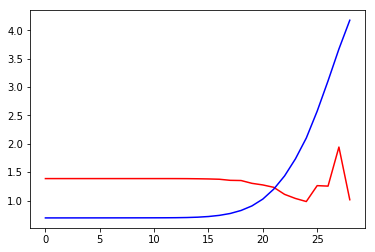

In [83]:
import matplotlib.pyplot as plt
plt.plot(D_list_cost,color = 'r')
plt.plot(G_list_cost,color = 'b')

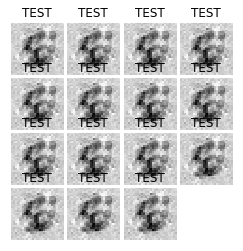

In [89]:
l=[]
for i in range(15):
    Z = np.random.normal(0., 1., size=[1, G_input])
    Gl1 = Z.dot(G_W1) + G_b1
    Gl1A = Lrelu(Gl1)
    Gl2 = Gl1A.dot(G_W2) + G_b2
    Gl2A = Lrelu(Gl2)
    Gl3 = Gl2A.dot(G_W3) + G_b3
    Gl3A = Lrelu(Gl3)
    Gl4 = Gl3A.dot(G_W4) + G_b4
    Gl4A = Lrelu(Gl4)
    Gl5 = Gl4A.dot(G_W5) + G_b5
    Gl5A = Lrelu(Gl5)
    Gl6 = Gl5A.dot(G_W6) + G_b6
    Gl6A = Lrelu(Gl6)
    Gl7 = Gl6A.dot(G_W7) + G_b7
    Gl7A = Lrelu(Gl7)
    Gl8 = Gl7A.dot(G_W8) + G_b8
    Gl8A = Lrelu(Gl8)
    Gl9 = Gl8A.dot(G_W9) + G_b9
    Gl9A = Lrelu(Gl9)
    Gl10 = Gl9A.dot(G_W10) + G_b10
    Gl10A = Lrelu(Gl10)
    Gl11 = Gl10A.dot(G_W11) + G_b11

    current_fake_data = log(Gl11)
    l.append(current_fake_data)
fig = plot(l,"TEST")
fig.savefig('Click_Me_{}.png'.format(str(iter).zfill(3)+"_Ginput_"+str(G_input)+ "_hiddenone"+str(hidden_input) + "_hiddentwo"+str(hidden_input2) + "_LR_" + str(learing_rate)), bbox_inches='tight')

1


In [0]:

print(len(grad_r_w1_part_2))

1


In [0]:
print(len(current_fake_data))

1


In [0]:
Z = np.random.normal(-1., 1., size=[1, G_input]) 
Gl1 = Z.dot(G_W1) + G_b1
Gl1A = Lrelu(Gl1)
Gl2 = Gl1A.dot(G_W2) + G_b2
Gl2A = Lrelu(Gl2)
Gl3 = Gl2A.dot(G_W3) + G_b3
Gl3A = Lrelu(Gl3)
Gl4 = Gl3A.dot(G_W4) + G_b4
Gl4A = Lrelu(Gl4)
Gl5 = Gl4A.dot(G_W5) + G_b5
Gl5A = Lrelu(Gl5)
Gl6 = Gl5A.dot(G_W6) + G_b6
Gl6A = Lrelu(Gl6)
Gl7 = Gl6A.dot(G_W7) + G_b7
Gl7A = Lrelu(Gl7)
Gl8 = Gl7A.dot(G_W8) + G_b8
Gl8A = Lrelu(Gl8)
Gl9 = Gl8A.dot(G_W9) + G_b9
Gl9A = Lrelu(Gl9)
Gl10 = Gl9A.dot(G_W10) + G_b10
Gl10A = Lrelu(Gl10)
Gl11 = Gl10A.dot(G_W11) + G_b11

In [0]:
Gl10 = Gl9A.dot(G_W10) + G_b10

In [0]:
len(Gl9A.dot(G_W10)+ G_b10)

1